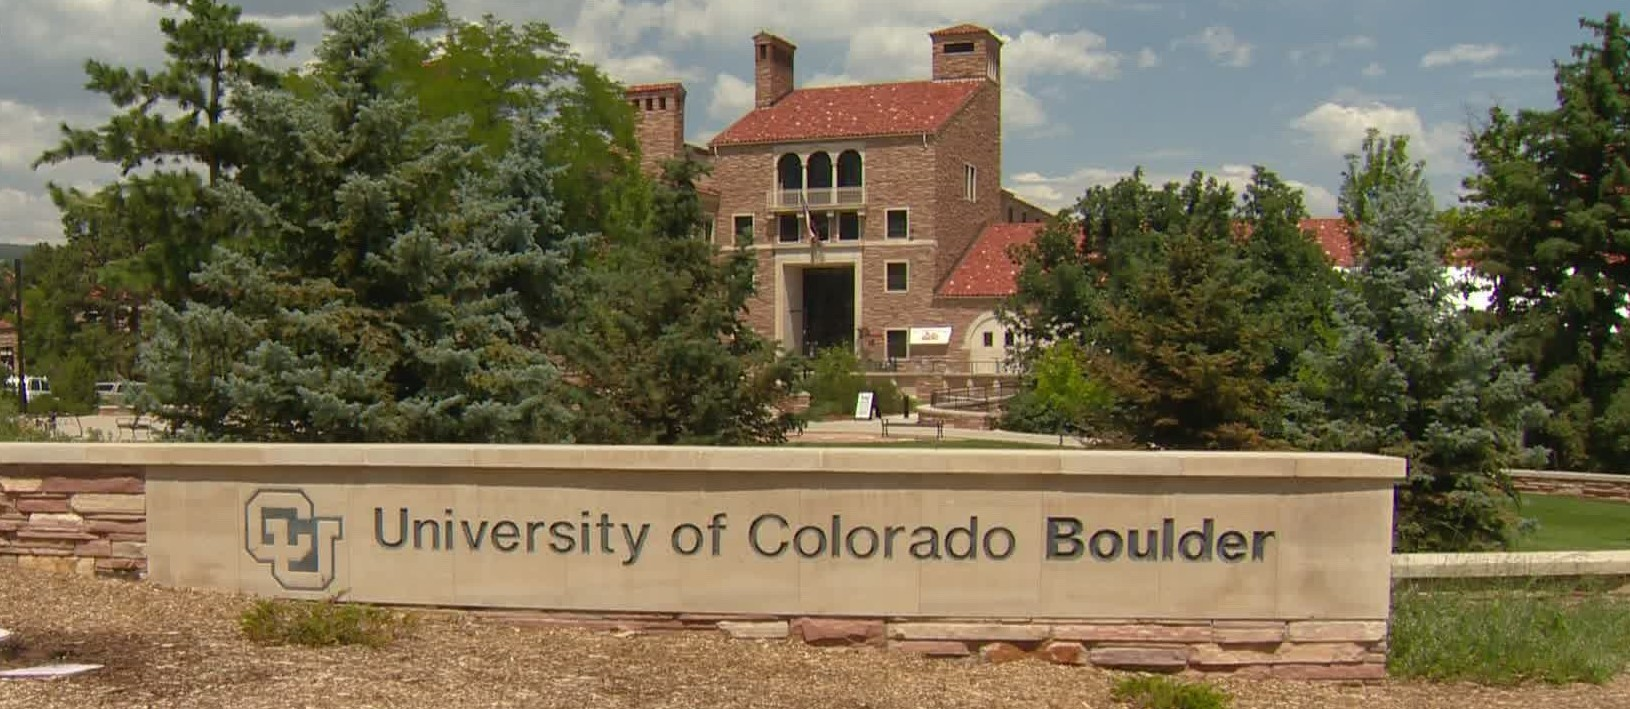

# Topic

This jupyter notebook is a project of the University of Colorado Boulder Master of Science in Data Science courese DTSA-5510 - Unsupervised Algorithms in Machine Learning.

For this week’s mini-project, you will participate in this Kaggle competition:  

Kaggle Competition: BBC News Classification

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. 

A Jupyter notebook with exploratory data analysis (EDA) procedure, model building and training, and comparison with supervised learning. 

Suppose your work becomes so large that it doesn’t fit into one notebook (or you think it will be less readable by having one large notebook). In that case, you can make several notebooks or scripts in a GitHub repository (as deliverable 3) and submit a report-style notebook or pdf instead.

## Data
The idea behind the problem as well as the data is based on Ryan L. Wood, Tanner Jensen, Cindi Wadsworth, Mark Clement, Prashant Nagpal and William G. Pitts paper "[Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full)".

Into the data where simulated measurement errors added by the kaggle team to make the problem  more chalanging.

The final test and train data could be found at [Kaggle competition page](https://www.kaggle.com/c/tabular-playground-series-feb-2022/data)

## Importing libraries

In [455]:
import pandas as pd
import numpy as np

# for performace patch
from sklearnex import patch_sklearn
patch_sklearn() # withe larger no of trees kernel dies
 
# disable  patching
#from sklearnex import unpatch_sklearn
#unpatch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import clear_output
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

from time import time # to messure running time

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import LabelEncoder # To encode string labels into numeric values
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier # Load random forest classifier 

#from sklearn.multiclass import OneVsRestClassifier
#from sklearn.svm import SVC

import joblib # For saving the trained model
import tensorflow as tf
import os

# For word embedding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
import io
import re
import shutil
import string



from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups


import itertools # For iteration over found categories and assign best match


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Please feel free to look at online resources on processing raw texts to feature vectors. Many methods process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a method and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words. Also, do exploratory data analysis such as word statistics and/or visualization.

As we did not learn natural language processing (NLP) specific techniques such as word embeddings in the lectures, we recommend reading discussions and example codes from others in the Kaggle and/or doing some research online to make sure you understand. You can refer to any resource as needed, but make sure you “demonstrate” your understanding- please include explaining in your own words, discussions, and your interpretation. Also importantly, please have a reference list at the end of the report. 

## Importing data, cleaning and analysis

### Import data and get first overview

I downloaded the data locally and saved it into my workdir of the project. 

In [418]:
df_train = pd.read_csv('BBC News Train.csv', index_col='ArticleId')
df_test  = pd.read_csv('BBC News Test.csv', index_col='ArticleId')
df_subm = pd.read_csv("BBC News Sample Solution.csv")#, index_col='ArticleId')

In [419]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 1490
Total number of columns: 2


In [420]:
df_test_row_count, df_test_column_count=df_test.shape
print('Total number of rows:', df_test_row_count)
print('Total number of columns:', df_test_column_count)

Total number of rows: 735
Total number of columns: 1


In [421]:
df_subm_row_count, df_subm_column_count=df_subm.shape
print('Total number of rows:', df_subm_row_count)
print('Total number of columns:', df_subm_column_count)

Total number of rows: 735
Total number of columns: 2


In [422]:
df_train.head()

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business


In [423]:
df_test.head()

,Text
ArticleId,
1018,qpr keeper day heads for preston queens park r...
1319,software watching while you work software that...
1138,d arcy injury adds to ireland woe gordon d arc...
459,india s reliance family feud heats up the ongo...
1020,boro suffer morrison injury blow middlesbrough...


In [424]:
df_subm.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


In [425]:
target_class = pd.DataFrame({'count': df_train.Category.value_counts(),
                             'percentage': df_train['Category'].value_counts() / df_train.shape[0] * 100
})
target_class

,count,percentage
sport,346,23.221477
business,336,22.550336
politics,274,18.389262
entertainment,273,18.322148
tech,261,17.516779


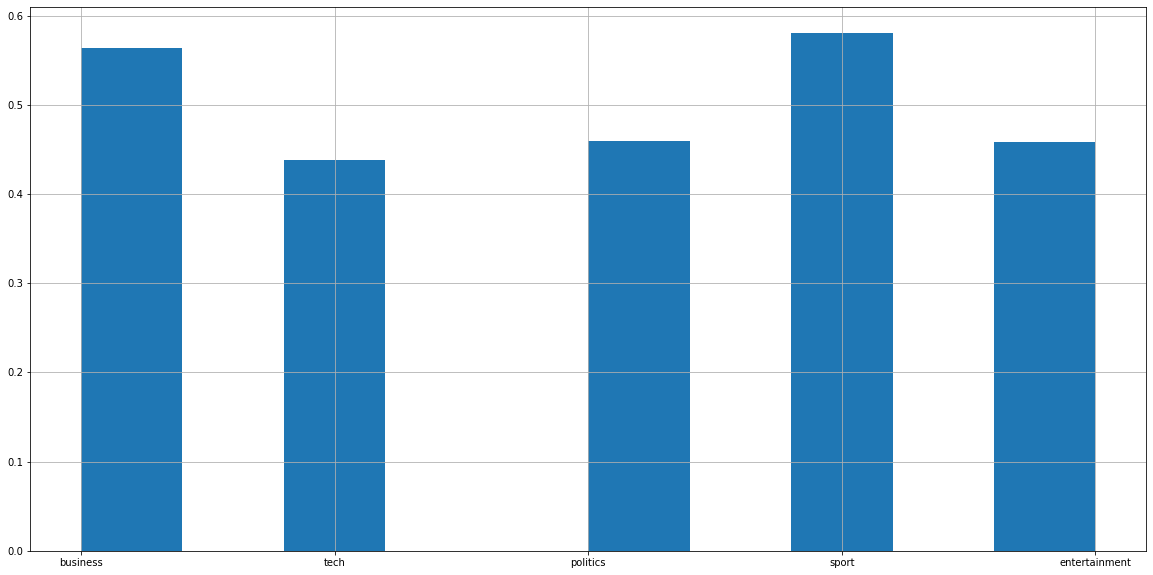

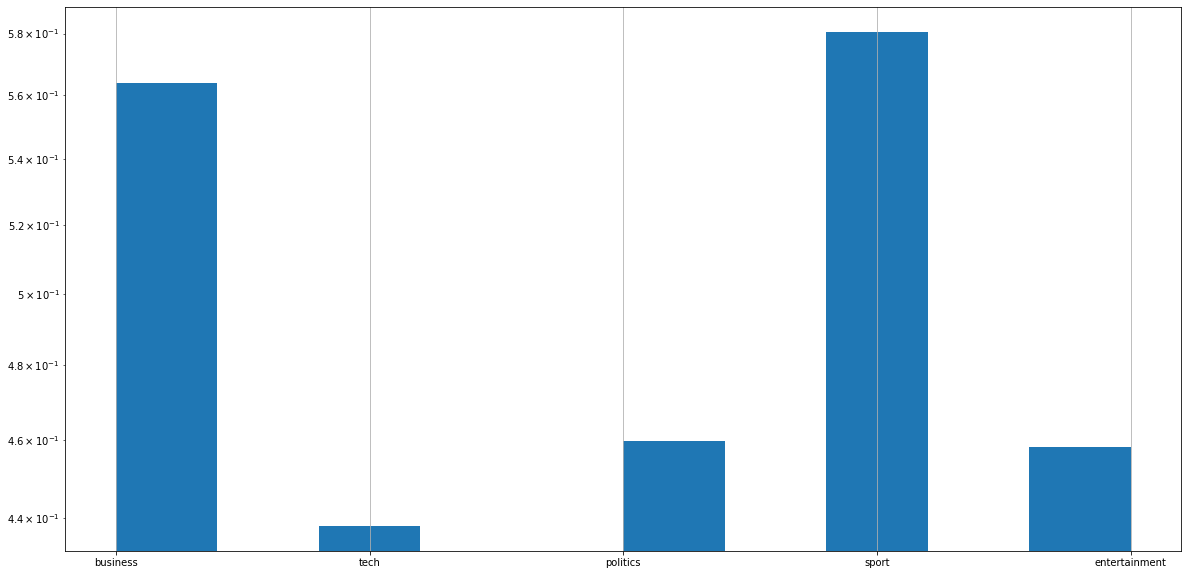

In [426]:
# increase size of plots
plt.rcParams["figure.figsize"] = (20,10)

# create a histogramm
plt.hist(df_train.Category, density=True)#, orientation='horizontal')
plt.grid(True)
plt.show()


# to visulize the difference better use also a log scale
plt.hist(df_train.Category, density=True, log=True)#, orientation='horizontal', log=True)
plt.grid(True)
plt.show()

Source data consits of of three files

- BBC News Train.csv
- BBC News Test.csv
- BBC News Sample Solution.csv

Train data contains 1490 rows and 3 columns. "ArticleId" with an ID of the article, "Text" with the headline of the article and "Category" with the ground truth of the category name as string.

The possible 5 categories are:

- sport
- tech
- business
- entertainment
- politics

Most frequent is sport and busines with around 23% followed by politics, entertainmentand tech with around 18% of the articles. (Detailed firgures within the table above)

Test data contains 735 rows and 2 columns. It alsco contains the "ArticleId" and "Text" but no targed value.

BBC News Sample Solution.csv is just a sample file how the Kaggle submission should look like and consits of 735 rows and 2 columns, one with the ID and and one for the predicted category.

### Further analysis and cleaning

In [427]:
# Verify size and data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1490 entries, 1833 to 538
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      1490 non-null   object
 1   Category  1490 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [428]:
# check distribution and min max values
df_train.describe().T

,count,unique,top,freq
Text,1490,1440,microsoft seeking spyware trojan microsoft is ...,2
Category,1490,5,sport,346


In [429]:
# check distribution and min max values
df_test.describe().T

,count,unique,top,freq
Text,735,722,boothroyd calls for lords speaker betty boothr...,2


### Check for missing values

In [430]:
df_train.isna().sum()

Text        0
Category    0
dtype: int64

In [431]:
sum(df_train.isna().sum())

0

In [432]:
df_test.isna().sum()

Text    0
dtype: int64

In [433]:
sum(df_train.isna().sum())

0

We have no NA values in the test or train set.

### Check for unique values

In [434]:
print ("Unique values are:\n",df_train.nunique())
print ("Max unique values are:\n",max(df_train.nunique()))

Unique values are:
 Text        1440
Category       5
dtype: int64
Max unique values are:
 1440


Dataset has 5 taget unique values as we already know. The ArticleId has up to 1490 unique values. Text has 1440 unique values so there must be some duplicates in "Text".

### Check for duplicate entries

In [435]:
# check for duplicate entries
print("duplicate entries in trainset:",df_train.duplicated(subset=['Text']).sum())
print("duplicate entries in testset:",df_test.duplicated(subset=['Text']).sum())


duplicate entries in trainset: 50
duplicate entries in testset: 13


Train as well as testset has duplicate entries. In testset we will keep these entries for correct prediction. In trainset we could drop the duplicate entries because they will give us no additional information.

In [436]:
# drop duplicate entries in train set
df_train = df_train.drop_duplicates(subset=['Text'])

In [437]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 1440
Total number of columns: 2


After data cleaning we are left with 1440 unique rows in trainset with one taget Category and one Text column. We have no NA or missing values.

### Create dataframes for ground truth (y) and features (X)

In [438]:
#Defining X and y
X = df_train.drop(['Category'], axis=1)
y = df_train['Category']

### Encode the string target labels into numeric values

In [439]:
# encode the targed labels from string into numeric
enc = LabelEncoder()
y = enc.fit_transform(y)

### Split dataset for training and internal testing

In [440]:
# creating dataset split for prediction

X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (1152, 1)
y_train: (1152,)
X_test: (288, 1)
y_test: (288,)


## Word embedding



I decided to use Bag of Words representation as embedding. Details could be found on sklearn website: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

There I found also some examples and demo code I used as base for building models below.

I used the TfidfVectorizer without english stop words and minimum and maximum accurence. In a nutshell the input string with text is convertet all into lowercase and all special characters are removed. Blank is used as seperater between the words. Than all stop words (words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text) are removed.

This is the input text for the tokenizing. In tokenizing a integer is assigned ti every unique word. Occurrences of words/token is counted per String and the weight are at the end normalized.

This matrix representation of the input strings is now used to feed and train the matrix factorization model. The model predicts probabilities for in this case 5 classes. Class with highest probability is choosen as target.

In [441]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,    #ignore terms that have a document frequency strictly higher than the given threshold 
    min_df=10,        #ignore terms that have a document frequency strictly lower than the given threshold#
#    max_features=10, #n_features, 
#    analyzer="char_wb", # {‘word’, ‘char’, ‘char_wb’} or callable, default=’wor
    stop_words="english"
)

# Vectorize words
t0 = time()
X_train_tf = tfidf_vectorizer.fit_transform(df_train["Text"])


print("Vectorization time:", time() - t0)

Extracting tf-idf features for NMF...
Vectorization time: 0.24156689643859863


## Building and training models.


In the Kaggle competition, the training data has labels (category). Thus, it can be solved using supervised learning. In general, the more labeled data we have, the more accurate the supervised learning model will be. But unsupervised learning can be powerful even when there is a small number of labels or no labels. This assignment will apply an unsupervised approach, especially the matrix factorization method, to discover topics in the news articles and use the labels to check the accuracy.

Here are some steps to guide this section: 
1. Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?
2. Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.
3. Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 
4. Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.
5. Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc

In [442]:
# Helper function to plot most frequent words. Adoptet from a function I found in the sklearn dokumentation

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

done in 0.268s.


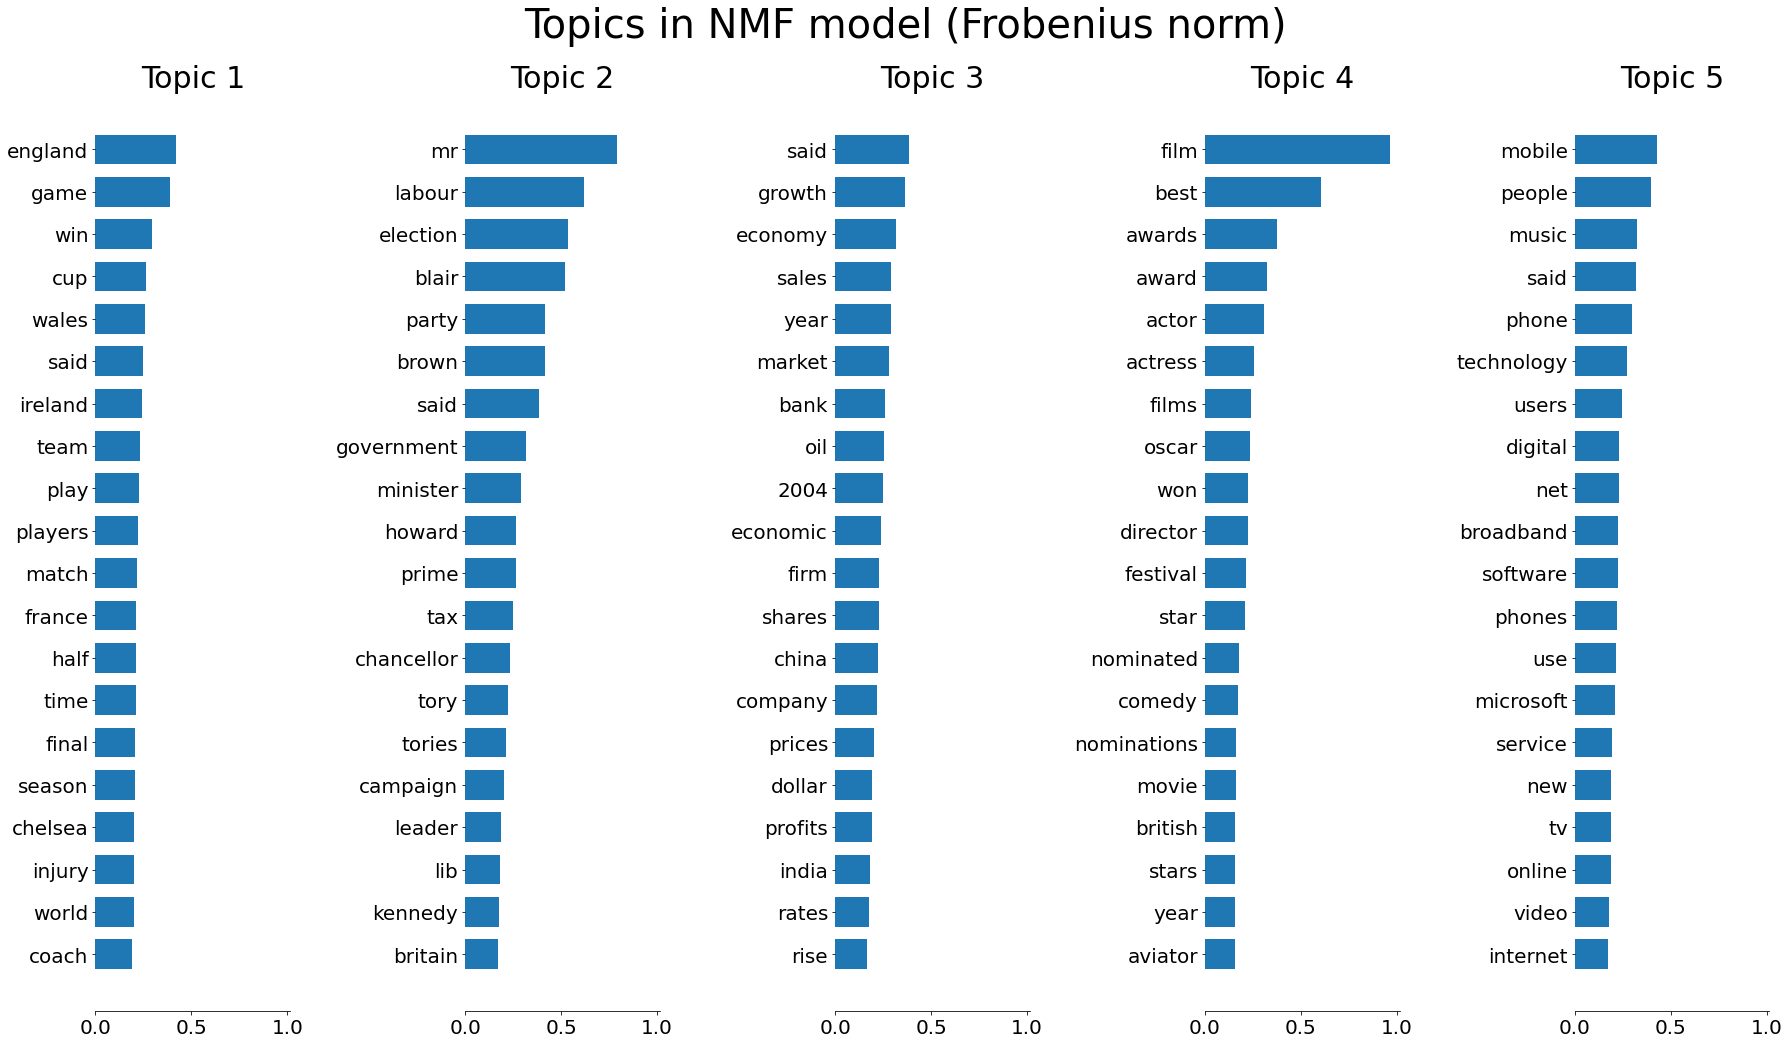

In [443]:
n_components = 5  # These are tthe 5 classes we try to predict
n_top_words = 20

# Fit the NMF model

t0 = time()
nmf = NMF(n_components=n_components, random_state=1, alpha=0.01, l1_ratio=0.5).fit(X_train_tf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [444]:
# create prediction probabilities
y_predict_prob = nmf.transform(X_train_tf)
print(y_predict_prob)

# index with highest probability is our predicted class
y_predict = np.argmax(y_predict_prob, axis=1)


[[0.         0.04156869 0.05614919 0.00153088 0.00487474]
 [0.         0.         0.20289645 0.         0.        ]
 [0.01927475 0.02330365 0.11733251 0.00080101 0.03121611]
 ...
 [0.00886883 0.         0.16266869 0.00843927 0.        ]
 [0.         0.         0.02255576 0.00341437 0.22732324]
 [0.         0.         0.         0.         0.13301729]]


In [445]:
# Helper function to find best matching labels sequence
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """

    labels = np.unique(ytdf)
    acc = list()
    permutations = list(itertools.permutations(range(n)))
    for permut in permutations:
        acc.append(accuracy_score(yp.replace(labels, permut), ytdf))
    return permutations[acc.index(max(acc))], max(acc)

# create dataframe
y_predictdf = pd.DataFrame(y_predict)

# check best labelorder
labelorder, acc = label_permute_compare(y, y_predictdf)
print("Best label order is:", labelorder, "With Accuracy:",acc)

# assign best labelorder to prediction
y_predictdf = y_predictdf.replace(np.unique(y_predictdf), labelorder)

Best label order is: (3, 2, 0, 1, 4) With Accuracy: 0.9027777777777778


[[310   1  12   1  11]
 [  5 193   6  11  48]
 [ 20   0 235   4   7]
 [  1   2   0 339   0]
 [  2   3   0   6 223]]


<AxesSubplot:>

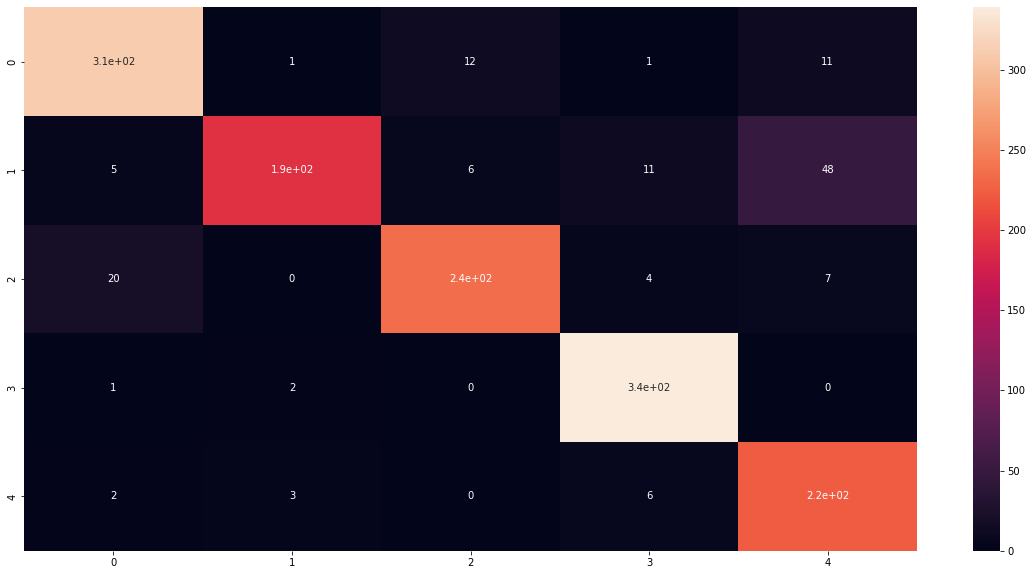

In [481]:
print(confusion_matrix(y, y_predictdf))

cm = pd.DataFrame(confusion_matrix(y, y_predictdf))
sns.heatmap(cm, annot=True)

### Final prediction on Kaggle Testset

In [448]:
# Vectorize words final testset
df_test_tf = tfidf_vectorizer.transform(df_test["Text"])

# Make final prediction 
y_submit_prob = nmf.transform(df_test_tf)

# index with highest probability is our predicted class
y_submit = np.argmax(y_submit_prob, axis=1)

# create dataframe
y_submit = pd.DataFrame(y_submit)

# assign best labelorder to prediction
y_submit = y_submit.replace(np.unique(y_submit), labelorder)

## Compare with supervised learning

Use the following steps to guide your work:

1. Pick and train a supervised learning method(s) and compare the results (train and test performance)
2. Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

## Random Forest Classifier

First approach is to use a random forrest classifier.

### Model selection

To find propper parameters I used parameter tuning via GridSearch with cross validation. I tried different combinations for the number of trees, the minimum sample split size, minimum number of sample leafgs and ccp alpha for pruning.

If you run the notebook please be aware that this will take a very long time dependingn on your hardware.

I did this comparisons and parameter tuning iterative and in severals runs. Therfore I have no homogenius output or nice plots. I summarized the results below which lead to the final model.

Beside grid search I also tried differend values for out of bag and maximum depth. Result was default values without limiting the depth of the tree or using out of bag has highes accuray in this case.

In [457]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'n_estimators':list(range(500,2001,500)), 'min_samples_split':list(range(2,11,2)), "min_samples_leaf":list(range(1,11,2))}

rf =  RandomForestClassifier(
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    max_leaf_nodes = None,
    bootstrap=True,  # bootstrap samples 
    oob_score=True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)


grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["Text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 c

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Paralle

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    

[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.8s finishe

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 co

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:  

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    

[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  

[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:  

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    

[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finishe

[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finishe

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 2000 out of 2000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1812 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:

[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | el

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    

[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1,
                                              warm_start=True),
             param_grid={'min_samples_leaf': [1, 3, 5, 7, 9],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [500, 1000, 1500, 2000]})

In [461]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9505208333333334
Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}


In [463]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'n_estimators':list(range(1500,2501,500))}

rf =  RandomForestClassifier(
    n_jobs=-1,
    min_samples_split = 2,
    min_samples_leaf = 1,
    random_state=42, 
    max_depth = None, #10
    max_leaf_nodes = None,
    bootstrap=True,  # bootstrap samples 
    oob_score=True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["Text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42, verbose=1,
                                              warm_start=True),
             param_grid={'n_estimators': [1500, 2000, 2500]})

In [465]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9505208333333334
Best parameters: {'n_estimators': 1500}


In [466]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.1,1.1,0.1))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["Text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elaps

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False, n_estimators=500,
                                              n_jobs=-1, random_state=42,
                                              verbose=1, warm_start=True),
             param_grid={'ccp_alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                       0.6, 0.7000000000000001, 0.8, 0.9,
                                       1.0]})

In [467]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.24045138888888892
Best parameters: {'ccp_alpha': 0.1}


In [468]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.logspace(np.log(0.0005), np.log(0.005), 10))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["Text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False, n_estimators=500,
                                              n_jobs=-1, random_state=42,
                                              verbose=1, warm_start=True),
             param_grid={'ccp_alpha': [2.5066721763645345e-08,
                                       4.517938642887828e-08,
                                       8.142975285464993e-08,
                                       1.467661509836486e-07,
                                       2.645261998154906e-07,
                                       4.767728111682978e-07,
                                       8.593187125807323e-07,
                                       1.5488061242039796e-06,
                                       2.791514225458448e-06,
                                       5.031328033353388e-06]})

In [469]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9505208333333334
Best parameters: {'ccp_alpha': 2.5066721763645345e-08}


In [470]:
# Using Random Forest Classifier

# use GridSearch for some parameter tuning on training data

parameters = {'ccp_alpha':list(np.arange(0.000001, 0.00001, 0.000001))}

rf =  RandomForestClassifier(
    n_estimators=500, #25000, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, #10
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=True, # For grid Search
    max_samples=None, # None = All 
    verbose = 1
)

grid = GridSearchCV(rf, parameters, cv=3)
grid.fit(tfidf_vectorizer.transform(X_train["Text"]), y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tas

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.3s finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False, n_estimators=500,
                                              n_jobs=-1, random_state=42,
                                              verbose=1, warm_start=True),
             param_grid={'ccp_alpha': [1e-06, 2e-06, 3e-06, 4e-06,
                                       4.9999999999999996e-06,
                                       5.999999999999999e-06, 7e-06, 8e-06,
                                       9e-06]})

In [471]:
print("Best Score:",grid.best_score_)
print("Best parameters:",grid.best_params_)
#print(grid.cv_results_)
#print("depth", [estimator.get_depth() for estimator in grid.best_estimator_.estimators_])

Best Score: 0.9505208333333334
Best parameters: {'ccp_alpha': 1e-06}


### Results of Random forrest parameter tuning

Summary of parameter tuning was that a ccp_alpha of 0, min_samples_leaf of 1, min_samples_split of 2 and 1500 trees will lead to the highest accuracy of the model.

### Final Model

In [472]:
#Create a final random forest Classifier
mrf = RandomForestClassifier(
    n_estimators=1500, # number of trees
    n_jobs=-1,
    random_state=42, 
    max_depth = None, 
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_leaf_nodes = None,
    bootstrap=False, #True,  # bootstrap samples 
    oob_score=False, #True, # out of bag
    warm_start=False, # For grid Search
    max_samples=None, # None = All 
    ccp_alpha=0,#9*10**-6    #Minimal Cost-Complexity Pruning
    verbose=1 # Enable massages during fit and predict (Level 2 shows every tree)
)

### final training on full data
After I selected the model with best performance I started training on full dataset. Remember I splited the dataset 80/20 for train and test before but for final training I use the full dataset and prediction is on the Kaggle testset.

In [473]:
t0_full = time() # Start time for training
    
# Train model with full dataset
mrf.fit(tfidf_vectorizer.transform(X["Text"]), y)
    
# End time for training
rf_time_train_full=time() - t0_full

print('Training time', rf_time_train_full)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:    1.0s


Training time 1.9094429016113281


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    1.3s finished


In [474]:
# Make prediction on testset
y_pred = mrf.predict(tfidf_vectorizer.transform(X_test["Text"]))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.3s finished


Random Forrest Accuracy: 1.0


<AxesSubplot:>

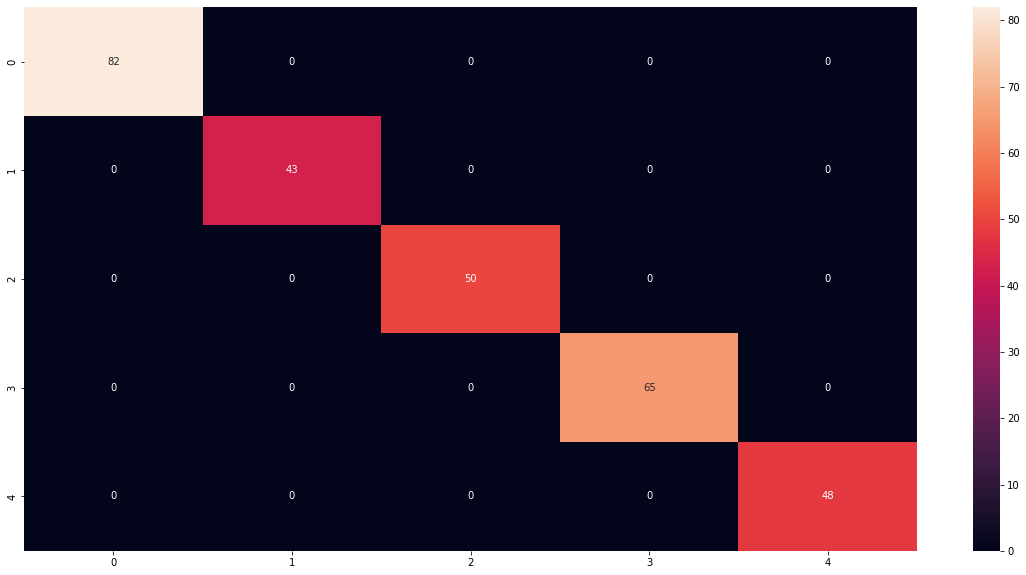

In [475]:
#Print Confusion Matrix
print("Random Forrest Accuracy:",metrics.accuracy_score(y_test, y_pred))
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, annot=True)

In this case we have accuracy of 1 on the tetset and therefore also in confusion matrix just machees in the diagonal. For the real testset on Kaggle I dont have the ground truth and therefore no cofusion matrix. But also there the accuracy is above 0.97.

### Final prediction on Kaggle Testset

In [476]:
# Make final prediction random forest
y_submit = mrf.predict(tfidf_vectorizer.transform(df_test["Text"]))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.4s
[Parallel(n_jobs=24)]: Done 1202 tasks      | elapsed:    0.7s
[Parallel(n_jobs=24)]: Done 1500 out of 1500 | elapsed:    0.9s finished


## Prepare submission

In [477]:
# encode original labels
y_submit = enc.inverse_transform(y_submit)

In [478]:
# create dataframe
y_submit = pd.DataFrame(y_submit)

# rename columns
y_submit.columns = ["Category"]

y_submit.head()

,Category
0,sport
1,tech
2,sport
3,business
4,sport


In [479]:
# Create submission

# Add "ArticleId" from testset
submission=pd.concat([df_subm['ArticleId'],y_submit],axis=1)

print(submission.head())

# Write submission file
submission.to_csv("submission.csv",index=False)

   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


## Conclusion

It took me quite long to get familiar with the vectorization of the text and to get the matrix factorization up and running. 
But after that was solfed the rest runs fine.

The performance on the test set was for the matrix factorization with 0.91156 already quide good.

But the Random Forrest Classifier I choos for supervised lerning outperfomed that with an accuracy of 0.97006.

Its allways impressiv how  unsupervised learning is able to structure and classify the data without any ground truth. Also the comutational performance is verry good. The matrix factorization model needs just 0.268 seconds to train, compared to 1.9 seconds for the randmo forrest.

The supervised lerning approach also has the risk of overfitting. Already here we see some overfitting with a train  accuracy of 1 conmpared to 0.97 in testset.